# **NVIDIA Stock Forecasting via Cross-Sectional Modeling**

## Dataset Overview

The NVIDIA Stock Price dataset provides daily historical stock data from July 28, 2011, to July 27, 2016, sourced from NASDAQ via Yahoo Finance. It contains 1,258 records and includes key financial indicators such as Open, High, Low, Close, Adjusted Close, and Volume.

This project focuses on modeling the closing price by converting the time series into a cross-sectional supervised learning problem. With engineered time-based features, the dataset serves as the foundation for forecasting using boosting algorithms like XGBoost, and for comparing these models to classical statistical methods.


[Dataset Link](https://github.com/antoinecarme/TimeSeriesData/tree/master/YahooFinance)

## **Data Inspection and Preparation**

Before we import and analyse our dataset, let's first create a cell fully dedicated to importing requirements

In [6]:
import pandas as pd
import numpy as np
import datetime
import itertools
import warnings
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats

from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

from tsfresh import extract_features
from tsfresh.feature_extraction import settings, EfficientFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

import xgboost as xgb

There were variety of stocks, but I chose NVIDIA, because dataset's period captures the company’s early growth phase before the major AI and GPU boom, allowing me to analyze how a tech stock performs leading up to significant industry shifts

In [8]:
nvda= pd.read_csv(r"C:\Users\user\Desktop\yahoo_NVDA.csv")

In [9]:
nvda.head()

,Unnamed: 0,Symbol,Date,Close,Low,Volume,Open,Adj_Close,High
0,0,NVDA,2016-07-27,56.060001,55.720001,11122600,57.119999,56.060001,57.220001
1,1,NVDA,2016-07-26,56.630001,56.090000,12862700,56.169998,56.630001,56.919998
2,2,NVDA,2016-07-25,55.680000,54.759998,7813200,55.000000,55.680000,55.810001
3,3,NVDA,2016-07-22,54.669998,53.020000,7894200,53.410000,54.669998,54.669998
4,4,NVDA,2016-07-21,53.220001,53.040001,9032700,54.099998,53.220001,54.270000


In [10]:
nvda = nvda.iloc[:, 2:]

In [11]:
nvda.head()

,Date,Close,Low,Volume,Open,Adj_Close,High
0,2016-07-27,56.060001,55.720001,11122600,57.119999,56.060001,57.220001
1,2016-07-26,56.630001,56.090000,12862700,56.169998,56.630001,56.919998
2,2016-07-25,55.680000,54.759998,7813200,55.000000,55.680000,55.810001
3,2016-07-22,54.669998,53.020000,7894200,53.410000,54.669998,54.669998
4,2016-07-21,53.220001,53.040001,9032700,54.099998,53.220001,54.270000


In [12]:
nvda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Close      1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Volume     1258 non-null   int64  
 4   Open       1258 non-null   float64
 5   Adj_Close  1258 non-null   float64
 6   High       1258 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [13]:
nvda['Date'] = pd.to_datetime(nvda['Date'])
print("\nDate range:", nvda['Date'].min(), "to", nvda['Date'].max())


Date range: 2011-07-28 00:00:00 to 2016-07-27 00:00:00


In [14]:
print(nvda.isnull().sum())

Date         0
Close        0
Low          0
Volume       0
Open         0
Adj_Close    0
High         0
dtype: int64


In [15]:
nvda = nvda.sort_values('Date')
date_range = pd.date_range(start=nvda['Date'].min(), end=nvda['Date'].max())
missing_dates = set(date_range) - set(nvda['Date'])
print(f"\nNumber of missing dates: {len(missing_dates)}")


Number of missing dates: 569


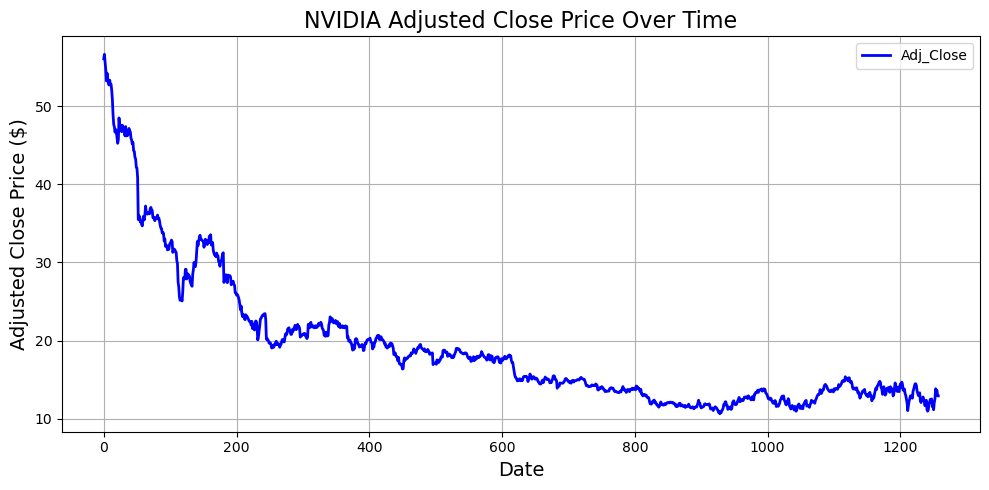

In [16]:
plt.figure(figsize=(10, 5))

plt.plot(nvda.index, nvda['Adj_Close'], label='Adj_Close', color='blue', linewidth=2)

plt.title('NVIDIA Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price ($)', fontsize=14)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Okay so we have a pretty good dataset, without any null values, having datatypes properly, and missing dates as it should be, because for the given interval the number of holidays and weekends (times where stock market is not active) matches perfectly with our missing dates number, so no further imputations needed here, we have completely clean and good dataset

Time to convert our time series to a cross-sectional problem and split it for further modeling. I will use tsfresh for the feature extraction and before extractiing, I will create some suggested and commonly used financial stock-related variables that could have some effect on our forecasting process

In [19]:
nvda['time_idx'] = range(len(nvda))
nvda['id'] = 1

for lag in [1, 2, 3, 5, 10, 20]:
    nvda[f'Close_lag_{lag}'] = nvda['Close'].shift(lag)
    nvda[f'Volume_lag_{lag}'] = nvda['Volume'].shift(lag)

# Create technical indicators
nvda['returns'] = nvda['Adj_Close'].pct_change()
nvda['log_returns'] = np.log(nvda['Adj_Close']).diff()

# Moving averages
for window in [5, 10, 20, 50]:
    nvda[f'SMA_{window}'] = nvda['Adj_Close'].rolling(window=window).mean()
    nvda[f'Volume_SMA_{window}'] = nvda['Volume'].rolling(window=window).mean()

# Volatility
nvda['volatility_10'] = nvda['returns'].rolling(window=10).std()
nvda['volatility_30'] = nvda['returns'].rolling(window=30).std()

# Price range features
nvda['daily_range'] = nvda['High'] - nvda['Low']
nvda['daily_range_pct'] = nvda['daily_range'] / nvda['Open']

nvda['target'] = nvda['Adj_Close'].shift(-1)

nvda = nvda.dropna()

window_size = 30
tsfresh_data = []

for i in range(window_size, len(nvda)):
    window = nvda.iloc[i-window_size:i].copy()
    window['id'] = i
    window['time_idx'] = range(window_size)
    tsfresh_data.append(window)

if tsfresh_data:
    tsfresh_df = pd.concat(tsfresh_data)

    tsfresh_features = extract_features(tsfresh_df,
                                   column_id='id',
                                   column_sort='time_idx',
                                   column_value='Close',
                                   impute_function=impute,
                                   default_fc_parameters=settings.EfficientFCParameters())

    feature_ids = tsfresh_features.index.tolist()
    nvda_subset = nvda.loc[feature_ids].copy()
    nvda_with_features = pd.merge(nvda_subset, tsfresh_features,
                                  left_index=True, right_index=True)
else:
    print("Not enough data for tsfresh feature extraction")
    nvda_with_features = nvda.copy()

Feature Extraction: 100%|██████████| 30/30 [00:15<00:00,  1.99it/s]


In [20]:
X = nvda_with_features.drop(['Date', 'time_idx', 'id', 'target', 'Adj_Close'], axis=1)
y = nvda_with_features['target']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [21]:
k = min(50, X_train.shape[1], X_train.shape[0])
selector = SelectKBest(f_regression, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features")
print("Selected features:")
for feature in selected_features:
    print(f"- {feature}")

Selected 50 features
Selected features:
- Close
- Low
- Open
- High
- Close_lag_1
- Close_lag_2
- Close_lag_3
- Close_lag_5
- Close_lag_10
- Close_lag_20
- SMA_5
- SMA_10
- SMA_20
- SMA_50
- Close__sum_values
- Close__abs_energy
- Close__median
- Close__mean
- Close__root_mean_square
- Close__minimum
- Close__c3__lag_1
- Close__c3__lag_2
- Close__c3__lag_3
- Close__quantile__q_0.1
- Close__quantile__q_0.2
- Close__quantile__q_0.3
- Close__quantile__q_0.4
- Close__quantile__q_0.6
- Close__quantile__q_0.7
- Close__quantile__q_0.8
- Close__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)
- Close__cwt_coeff

In [22]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("Starting hyperparameter tuning...")
grid_search.fit(X_train_selected, y_train)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_selected)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTuned XGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Starting hyperparameter tuning...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters found by GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best RMSE: 6.0753

Tuned XGBoost Performance:
MAE: 0.30
RMSE: 0.37
R²: 0.8616


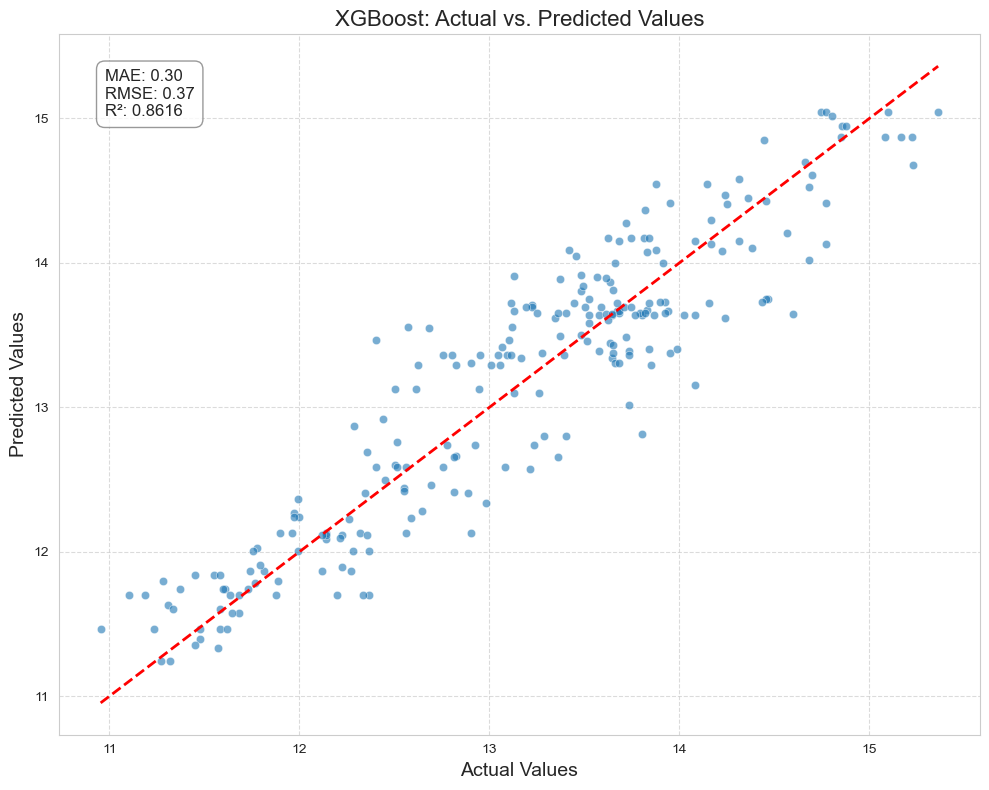

In [23]:
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})

plt.figure(figsize=(10, 8))

sns.set_style('whitegrid')
ax = sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6, color='#1f77b4')

max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('XGBoost: Actual vs. Predicted Values', fontsize=16)

metrics_text = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}'
plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=12, ha='left', va='top')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

What can we say about this metrics is that we have a really strong performance by XGBoost. We got really good R squared, which gives us 86% of variance explained and our MAE and RMSE also yields consistent performance, with really close predictions to the actual prices

Now let's try to train and evaluate the classical forecasting model, which is ARIMAX, because in the last assignment it had the best results for the stock prediction and compare it to the XGBoost

In [26]:
nvda= pd.read_csv(r"C:\Users\user\Desktop\yahoo_NVDA.csv")
nvda = nvda.iloc[:, 2:]
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda = nvda.sort_values('Date')
nvda = nvda.set_index('Date')
nvda.head()

,Close,Low,Volume,Open,Adj_Close,High
Date,,,,,,
2011-07-28,13.83,13.59,16204400,13.81,12.914859,14.12
2011-07-29,13.83,13.62,16941400,13.69,12.914859,13.96
2011-08-01,14.57,14.03,25490500,14.15,13.605893,14.61
2011-08-02,14.42,14.42,33910800,14.47,13.465819,15.38
2011-08-03,14.81,14.31,19130900,14.45,13.830012,14.86


In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(nvda.index, nvda['Adj_Close'], label='Adj_Close', color='blue', linewidth=2)

plt.title('NVIDIA Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price ($)', fontsize=14)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def check_stationarity(series, title):
    result = adfuller(series.dropna())

    print(f"ADF Test for {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] <= 0.05:
        print("Conclusion: Series is stationary (reject H0)")
        return True
    else:
        print("Conclusion: Series is non-stationary (fail to reject H0)")
        return False

is_stationary = check_stationarity(nvda['Adj_Close'], 'Adjusted Close Price')

if not is_stationary:
    nvda['Adj_Close_diff'] = nvda['Adj_Close'].diff().dropna()

    is_diff_stationary = check_stationarity(nvda['Adj_Close_diff'], 'Differenced Adjusted Close Price')

    plt.figure(figsize=(10, 5))
    plt.plot(nvda['Adj_Close_diff'].index, nvda['Adj_Close_diff'], color='purple', linewidth=2)
    plt.title('Differenced NVIDIA Adjusted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Differenced Adjusted Close Price ($)')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    d = 1
else:
    d = 0

In [ ]:
train_size = int(len(nvda) * 0.8)
train_data = nvda.iloc[:train_size]
test_data = nvda.iloc[train_size:]

I could not include the part where I found out the best parameters for the ARIMA model, because it would not let me import the auto_arima library in collab for some version dismatch, so I did that seprately in vscode and turned out that 3, 2, 0 are the optimal parameters

In [ ]:
warnings.filterwarnings('ignore')

exog_train = train_data[['Volume']]
exog_test = test_data[['Volume']]

p, d, q = 3, 2, 0

model = ARIMA(train_data['Adj_Close'], exog=exog_train, order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())

predictions = fitted_model.forecast(steps=len(test_data), exog=exog_test)

mae = mean_absolute_error(test_data['Adj_Close'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['Adj_Close'], predictions))
r2 = r2_score(test_data['Adj_Close'], predictions)

print("\nARIMAX Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

In [ ]:
if isinstance(predictions, (pd.Series, pd.Index)):
    pred_values = predictions.values
else:
    pred_values = predictions

results_df = pd.DataFrame({
    'Actual': test_data['Adj_Close'].values,
    'Predicted': pred_values
}, index=test_data.index)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

plt.figure(figsize=(16, 8))

plt.plot(results_df.index, results_df['Actual'], label='Actual', linewidth=2, color='blue')

plt.plot(results_df.index, results_df['Predicted'], label='Predicted', linewidth=2, 
         linestyle='--', color='red')

plt.title('NVIDIA Stock Price: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

print("First 5 rows of the results:")
print(results_df.head())

plt.show()

So we got our final results like following:

**XGBoost Metrics**:
- MAE: 0.30
- RMSE: 0.37
- R²: 0.8616

**ARIMAX Metrics**:
- MAE: 2.97
- RMSE: 3.74
- R²: 0.8252

Both models demonstrate strong predictive power for our NVDIA stock prices, having XGBoost clearly outperforminhg ARIMAX. While the models achieve similar R squared, XGBoost delivers much better precision with approximately 10 times lower error rates. This was pretty expectable, because XGBoost is a modern machine learning approach, utilizing 50 engineered features, while ARIMAX is traditional statistical model capturing only linear relationships. To sum up, both of them had quite good results, but XGBoost is much more reliable and useful model for stock price prediction, because it has ability to capture complex non-linear relationships.